<a href="https://colab.research.google.com/github/laurabishop/MusicDiscoveryPupil/blob/main/MusicDiscoveryPhysiology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Physiological Data Collected during Music Listening: Pupillometry


The eye's pupil dilates in response to increases in mental effort (i.e., the amount of attention and cognitive arousal that is evoked by a task). Under carefully controlled visual conditions, pupil diameter can be used as a psychophysiological index of attention. Pupil size can be captured using eye-tracking technology. Modern eye-trackers use cameras to measure the position and size of the pupil at a high frame rate.

In this part of the tutorial, we are going to explore eye-tracking data that were captured during a music discovery task.

In [1]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

In [2]:
shell_call("git clone https://github.com/laurabishop/MusicDiscoveryPupil")

In [ ]:
install.packages(c("ggplot2", "FBN", "mgsub", "sciplot"), lib = "/usr/local/lib/R/site-library")
lapply(c("ggplot2", "FBN", "mgsub", "sciplot"), require, character.only = TRUE)

## 1. Pre-processing of pupil data
### 1.1 Blinks
Pupil data normally contain blinks and other artifacts that should be removed before the data are used for any analysis. Below is an example of data containing blinks. A few samples are captured while the pupil is fully covered by the eyelid, resulting in a pupil size of 0 mm. A few samples are also captured while the eye is only partially covered by the eyelid. This results in a pupil size that is greater than 0, but much smaller than the average size for the trial. When pupil data are filtered, both complete and partial blinks need to be accounted for.

In [4]:
blink <- read.table("MusicDiscoveryPupil/PLR.txt", skip = 32, header = T, sep = ";")
blink$trialtime <- with(blink, (Time-Time[1])*(10^-6))

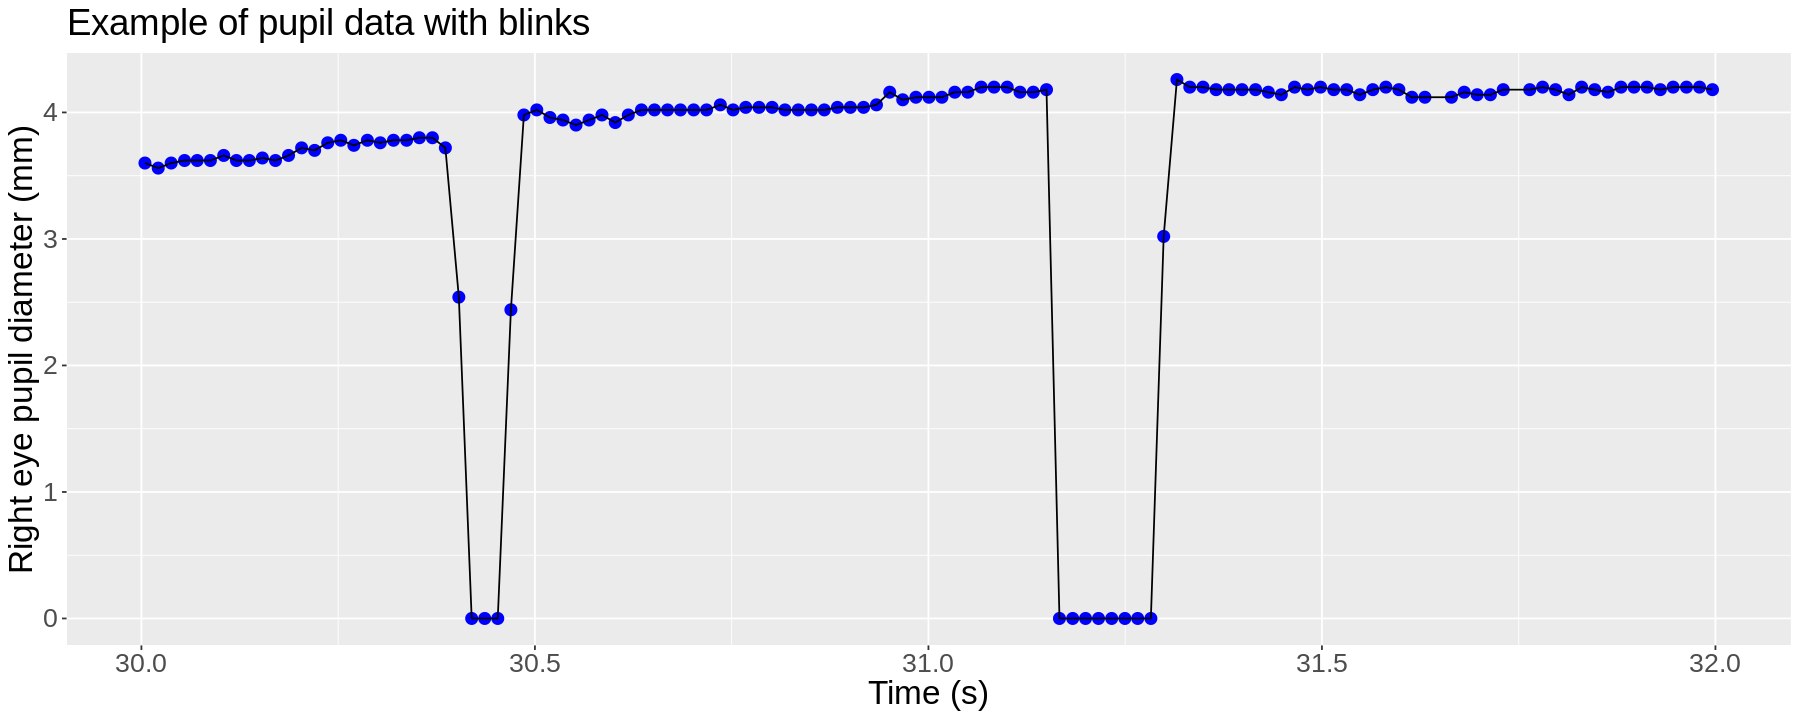

In [5]:
options(repr.plot.width = 15, repr.plot.height = 6)
ggplot(blink[blink$trialtime > 30 & blink$trialtime < 32, ],
aes(x = trialtime, y = R.Pupil.Diameter..mm.)) + geom_point(size = 3, colour = "blue") + geom_line() +
  xlab("Time (s)") + ylab("Right eye pupil diameter (mm)") +
  ggtitle("Example of pupil data with blinks") +
  theme(plot.title = element_text(size = 22), axis.text = element_text(size = 16), axis.title = element_text(size = 20))

### 1.2 Filtering pupil data
Some eye-tracking software includes a function for distinguishing fixations, saccades, and blinks:


*   **Fixations** occur when gaze is maintained on a single location
*   **Saccades** occur when gaze rapidly moves between locations
*   **Blinks** occur when the eye is fully or partially covered by the eyelid


Using such a function, you can get "clean" data for analysis by extracting only the fixations -- noting that fixations will not be evenly spaced in time. Fixation data is best for very detailed analysis of pupil dilations, because saccades (and blinks, of course) add noise to pupil data. If a blink detection function is not available or reliable, it may be necessary to work with raw data and filter out blinks and artifacts during pre-processing.

**Visualizing pupil data with blinks.** Below is an example of data from the Music Discovery dataset. Blinks are coded as NA in these data, so they appear as brief gaps. The "edges" of blinks appear as instantaneous drops in pupil size. There is also a longer period of missing data towards the end of the trial (probably because the participant looked away from the eye-tracker).

**Differences in size between left and right pupils.** Note that the left and right pupils follow similar trajectories, but are not identical in diameter. There is commonly a small difference between eyes in recorded pupil size, which is partially attributable to physiological differences between the eyes, and also sometimes partially attributable to measurement error (especially if the participant looks at more extreme angles or moves their head). Typically, pupillometry studies either use data from one eye or average data across both eyes.

In [7]:
eyetracking <- read.table("MusicDiscoveryPupil/P2067560969.txt")


In [8]:
session.no <- 1
track <- "3c879SgICdtgNLUdzHHs8F"
tdata <- eyetracking[eyetracking$session == session.no & eyetracking$spotify_id == track, ]

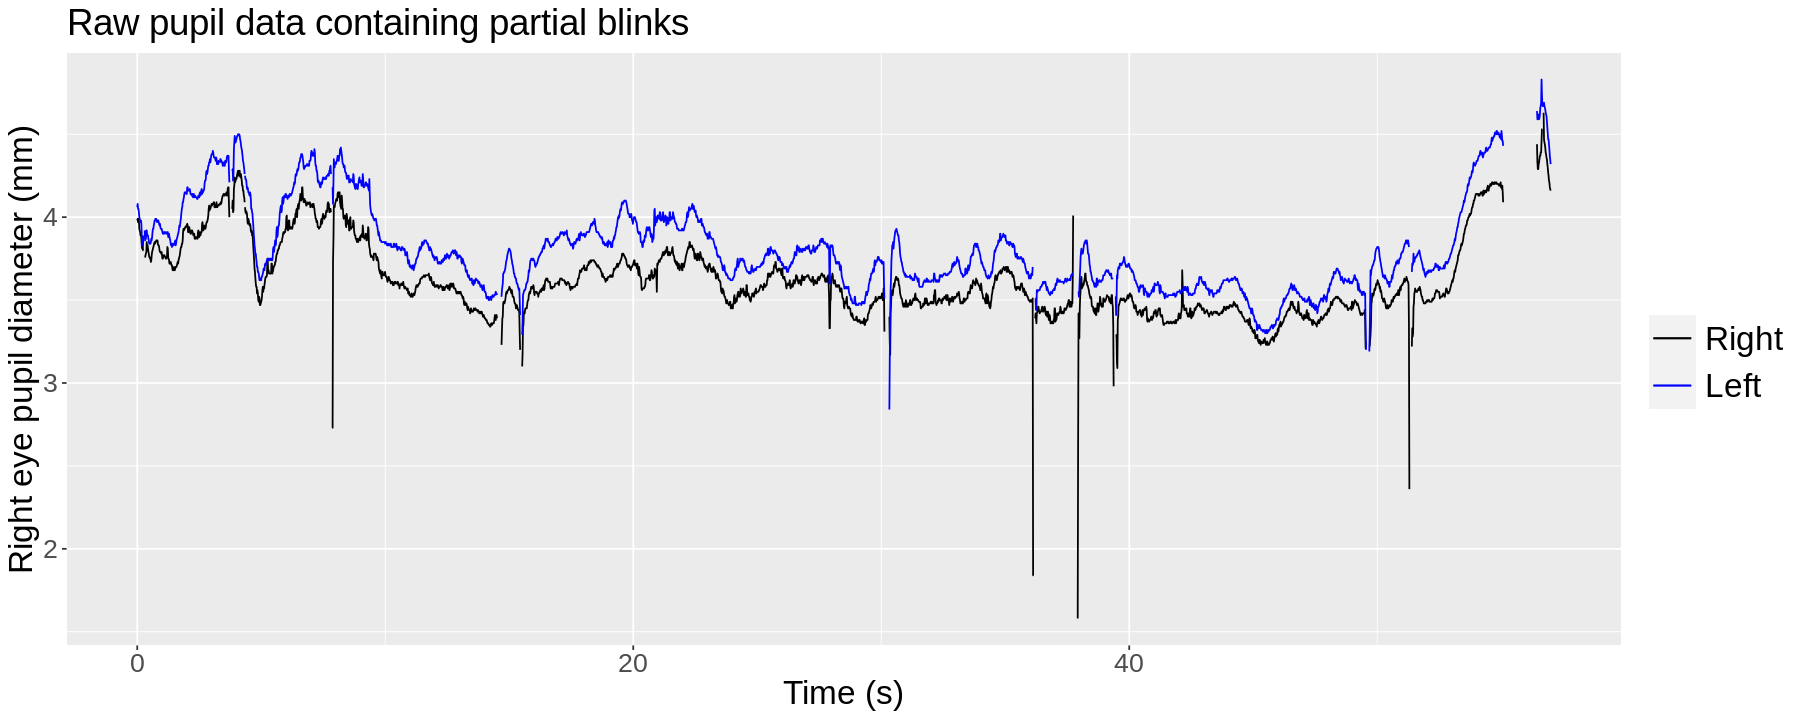

In [25]:
raw.plot <- ggplot(tdata, aes(x = tracktime)) + #xlim(30,40) +
                geom_line(aes(y = Pupil.diameter.right..mm., colour = "Right")) +
                geom_line(aes(y = Pupil.diameter.left..mm., colour = "Left")) +
                scale_colour_manual("", breaks = c("Right", "Left", "Smoothed", "Interpolated"),
                                    values = c("black", "blue", "red", "orange")) +
                ggtitle("Raw pupil data containing partial blinks") +
                xlab("Time (s)") + ylab("Right eye pupil diameter (mm)") +
                theme(plot.title = element_text(size = 22),
                      axis.text = element_text(size = 16), axis.title = element_text(size = 20),
                      legend.text = element_text(size = 20), legend.key.size = unit(1, "cm"))
raw.plot

We run a filter on these data that includes several steps. This is a customizable filter that is intended to work with data collected under different conditions using different eye-tracking devices. Depending on the quality of the data and the aim of the analyses, some steps might be skipped (e.g., smoothing). It might also be necessary to change some of the parameters. In this demo, we run steps 2-6, and the filter outputs a single continuous (i.e., without gaps) vector of smoothed pupil data.

* **Step 1**: *We skip this step here because the data do not contain values of 0.* Some data contain pupil sizes of 0, which arise during complete blinks or in moments where the pupil cannot be detected--for example, because the participant looks away from the eyetracker. Some software might code these values as NA (missing data) instead of 0. If values of 0 are present in the data, the first step would be to exclude them and replace them with NAs.
* **Step 1**: Filter out extreme velocities for each pupil individually. This targets the "edges" of blinks and other sudden changes in pupil size that arise because of mis-tracking.
* **Step 2**: Average left and right pupils.
* **Step 3**: Filter out extreme low values. Mostly these are samples from partial blinks that have excaped the velocity filter.
* **Step 4**: Run a linear interpolation to fill gaps. You can use other types of interpolations here. For example, a spline interpolation might be prefered in some cases (depending on how the data look, what size of gaps you need to fill, and what your eventual analysis will be). Here, we have some large gaps in some trials and prefer to maintain the average (tonic) pupil size in those cases.
* **Step 5**: Run a median filter to smooth the data.


In [13]:
outlier.value <- 3 # Used for defining outlier velocities in pupil filtering
low.threshold <- 2 # Used for cutting off values that are too far below trial mean
window.size <- 17 # Used to set the smoothing window

In [14]:
# Filter out extreme velocities for left pupil
tdata$xmm_velLeft <- with(tdata, c(NA, diff(Pupil.diameter.left..mm.))/c(NA, diff(timestamp)))
out.boundLeft <- outlier.value * sd(tdata$xmm_velLeft, na.rm = T)
tdata$xmm_ppLeft <- with(tdata, ifelse(abs(xmm_velLeft) > out.boundLeft, NA, Pupil.diameter.left..mm.))

# Filter out extreme velocities for right pupil
tdata$xmm_velRight <- with(tdata, c(NA, diff(Pupil.diameter.right..mm.))/c(NA, diff(timestamp)))
out.boundRight <- outlier.value * sd(tdata$xmm_velRight, na.rm = T)
tdata$xmm_ppRight <- with(tdata, ifelse(abs(xmm_velRight) > out.boundRight, NA, Pupil.diameter.right..mm.))

# Average filtered left and right pupils, then filter out extreme low values
tdata$pupil_lr <- with(tdata, (xmm_ppLeft + xmm_ppRight)/2)
low.bound <- mean(tdata$pupil_lr, na.rm = T) - low.threshold * sd(tdata$pupil_lr, na.rm = T)
tdata$xmm_ppp <- with(tdata, ifelse(pupil_lr < low.bound, NA, pupil_lr))

# Interpolate to fill gaps
tdata$pupil <- with(tdata, approx(timestamp, xmm_ppp, xout = timestamp)$y)

# Smoothing
tdata$smooth.pupil <- medianFilter(tdata$pupil, windowSize = window.size)

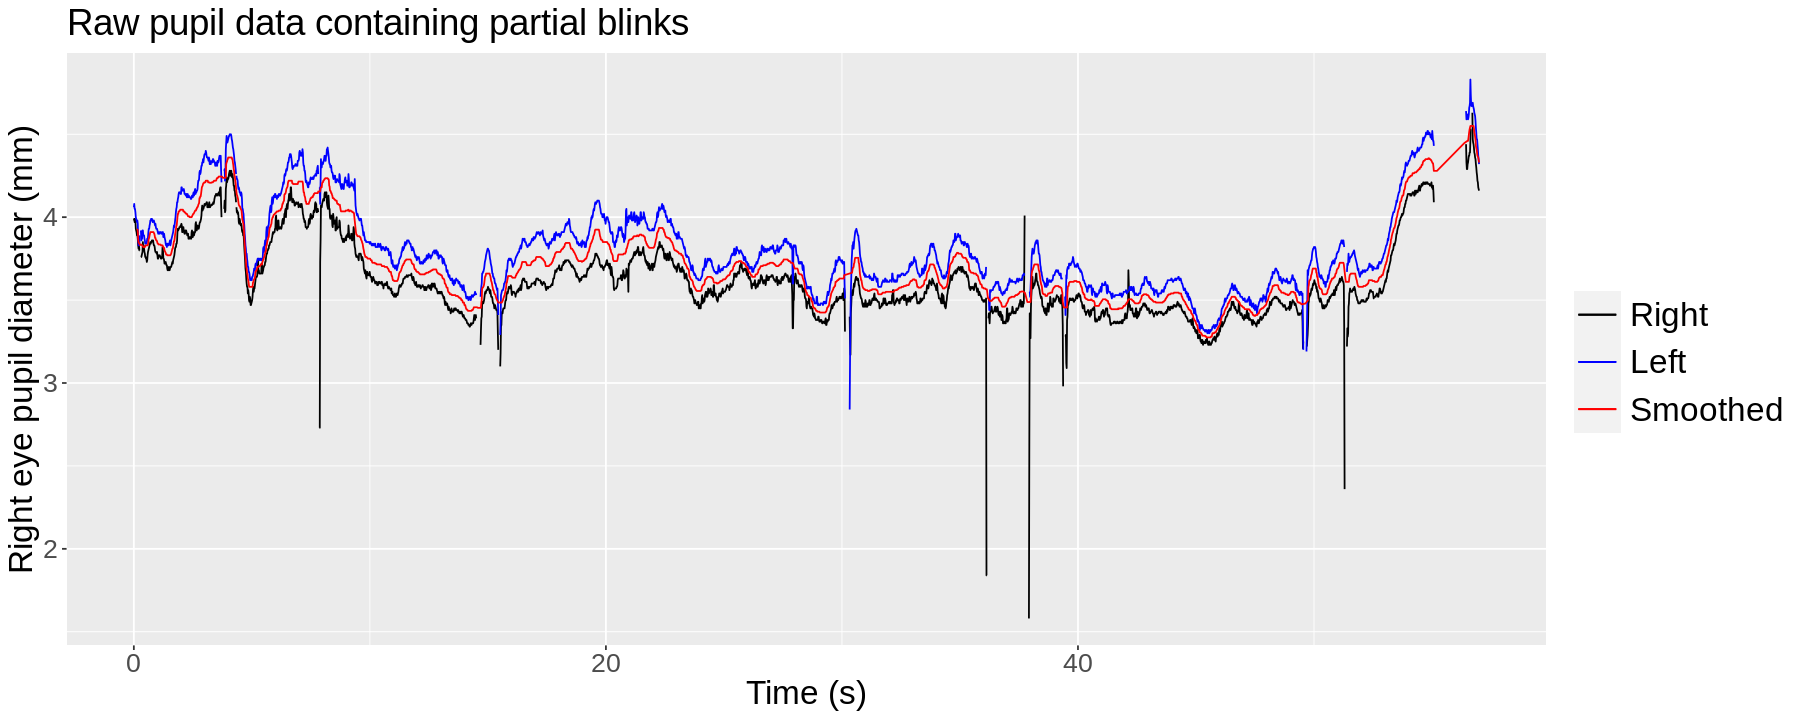

In [26]:
raw.plot <- raw.plot + geom_line(data = tdata, aes(y = smooth.pupil, colour = "Smoothed"))
#raw.plot <- raw.plot + geom_line(data = tdata, aes(y = pupil, colour = "Interpolated")) + xlim(0, 10)
suppressWarnings(print(raw.plot))

## 2. Analysis of pupil data

In this part of the tutorial, we address three questions:

*   How does pupil size relate to self-reported mental effort (RSME scale)?
*   How does pupil size relate to liking and familiarity?
*   Does pupil size predict listeners' emotional response?



### 2.1 How does pupil size relate to self-reported mental effort (RSME scale)?

During the music discovery experiment, participants rated their mental effort on the RSME at the end of each trial.

Theoretically, subjective (RSME) and objective (pupil size) measures of mental effort should be positively related. We can test whether this is the case for our data, using a Spearman correlation.

In [28]:
filtered <- read.table("MusicDiscoveryPupil/ET-partial1.txt")

In [29]:
pupilxRSME <- aggregate(smooth.pupil ~ RSME + ID + spotify_id + session,
                        data = filtered, mean)
pupilxRSME$ID <- as.character(pupilxRSME$ID)

`geom_smooth()` using formula = 'y ~ x'


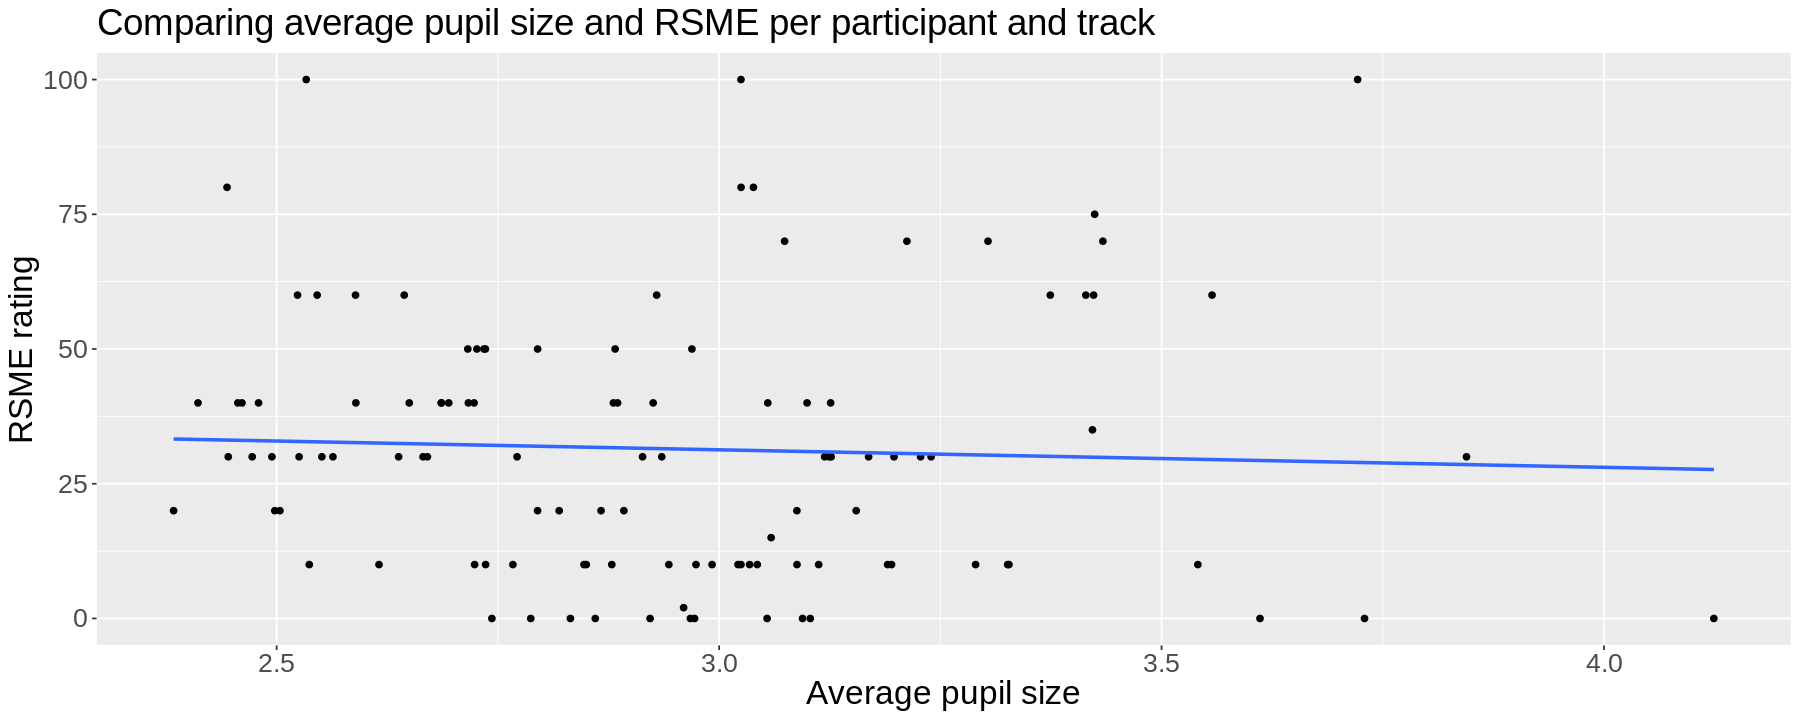

In [31]:
options(repr.plot.width = 15, repr.plot.height = 6)
effort.noID <- ggplot(pupilxRSME, aes(x = smooth.pupil, y = RSME)) + geom_point()
effort.noID <- effort.noID + ggtitle("Comparing average pupil size and RSME per participant and track") +
                                    xlab("Average pupil size") + ylab("RSME rating") +
                                    theme(plot.title = element_text(size = 22),
                                        axis.text = element_text(size = 16), axis.title = element_text(size = 20),
                                        legend.text = element_text(size = 20), legend.key.size = unit(1, "cm"),
                                        legend.title = element_text(size = 20))
effort.noID + geom_smooth(method = lm, se = FALSE)

`geom_smooth()` using formula = 'y ~ x'


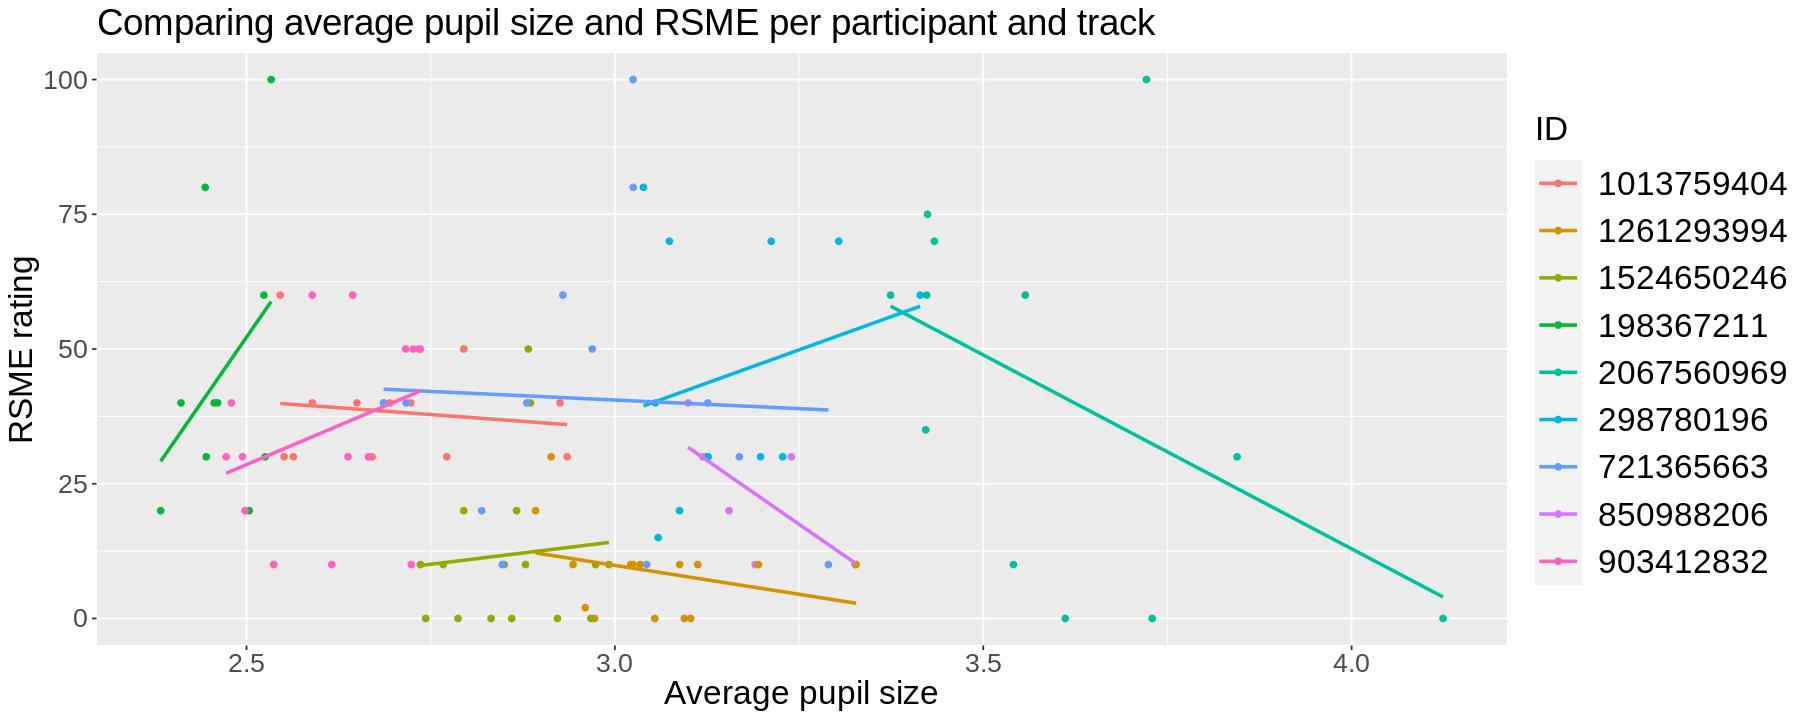

In [32]:
effort <- ggplot(pupilxRSME, aes(x = smooth.pupil, y = RSME, colour = ID)) + geom_point()
effort <- effort + ggtitle("Comparing average pupil size and RSME per participant and track") +
                          xlab("Average pupil size") + ylab("RSME rating") +
                          theme(plot.title = element_text(size = 22),
                                axis.text = element_text(size = 16), axis.title = element_text(size = 20),
                                legend.text = element_text(size = 20), legend.key.size = unit(1, "cm"),
                                legend.title = element_text(size = 20))
effort + geom_smooth(method = lm, se = FALSE)

In [33]:
with(pupilxRSME, cor.test(smooth.pupil, RSME, method = "spearman", exact = F))


	Spearman's rank correlation rho

data:  smooth.pupil and RSME
S = 261723, p-value = 0.216
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1178251 


**Conclusions.** From the plot, we see that some participants used more of the RSME scale than others. The correlation is slightly but non-significantly negative, in contrast to our hypothesis. A possible explanation is that participants could not readily apply the concept of mental effort to a task that was generally enjoyable and that they associate with relaxation (i.e., listening to music - see also the results below on emotional response).



### 2.2 How does pupil size relate to liking and familiarity?

Participants reported how much they liked each track and how familiar they were with each track on a scale of 1-7.


*   **Liking:** Looking at the distribution of liking scores, we see that there were many more positive ratings (between 5 - 7) than negative or neutral ratings (< 5), and no ratings of 1. This skewed distribution is not optimal for testing the relationship between pupil size and liking.
*   **Familiarity:** Participants used the entire scale, and tended to be unfamiliar with the music, at least during the first session.






In [34]:
dist <- aggregate(cbind(liking, track_familiarity) ~ ID + spotify_id + session, filtered, mean)
table(dist$liking)


 2  3  4  5  6  7 
 2 11  7 24 33 35 

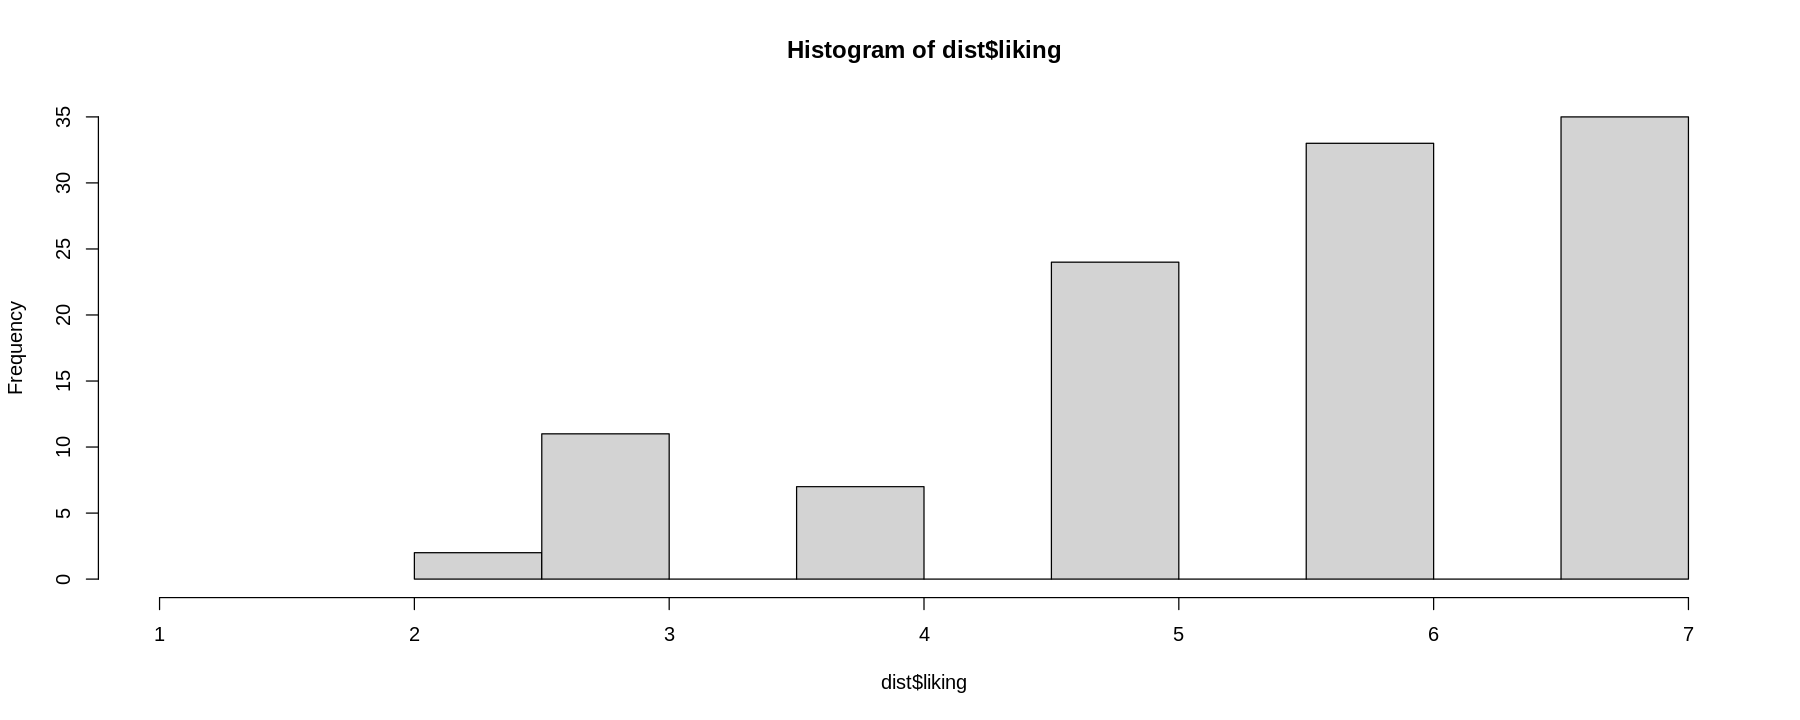

In [35]:
hist(dist$liking, xlim = c(1, 7))

In [36]:
table(dist$track_familiarity)


 1  2  3  4  5  6  7 
33  8  9  8 27 20  7 

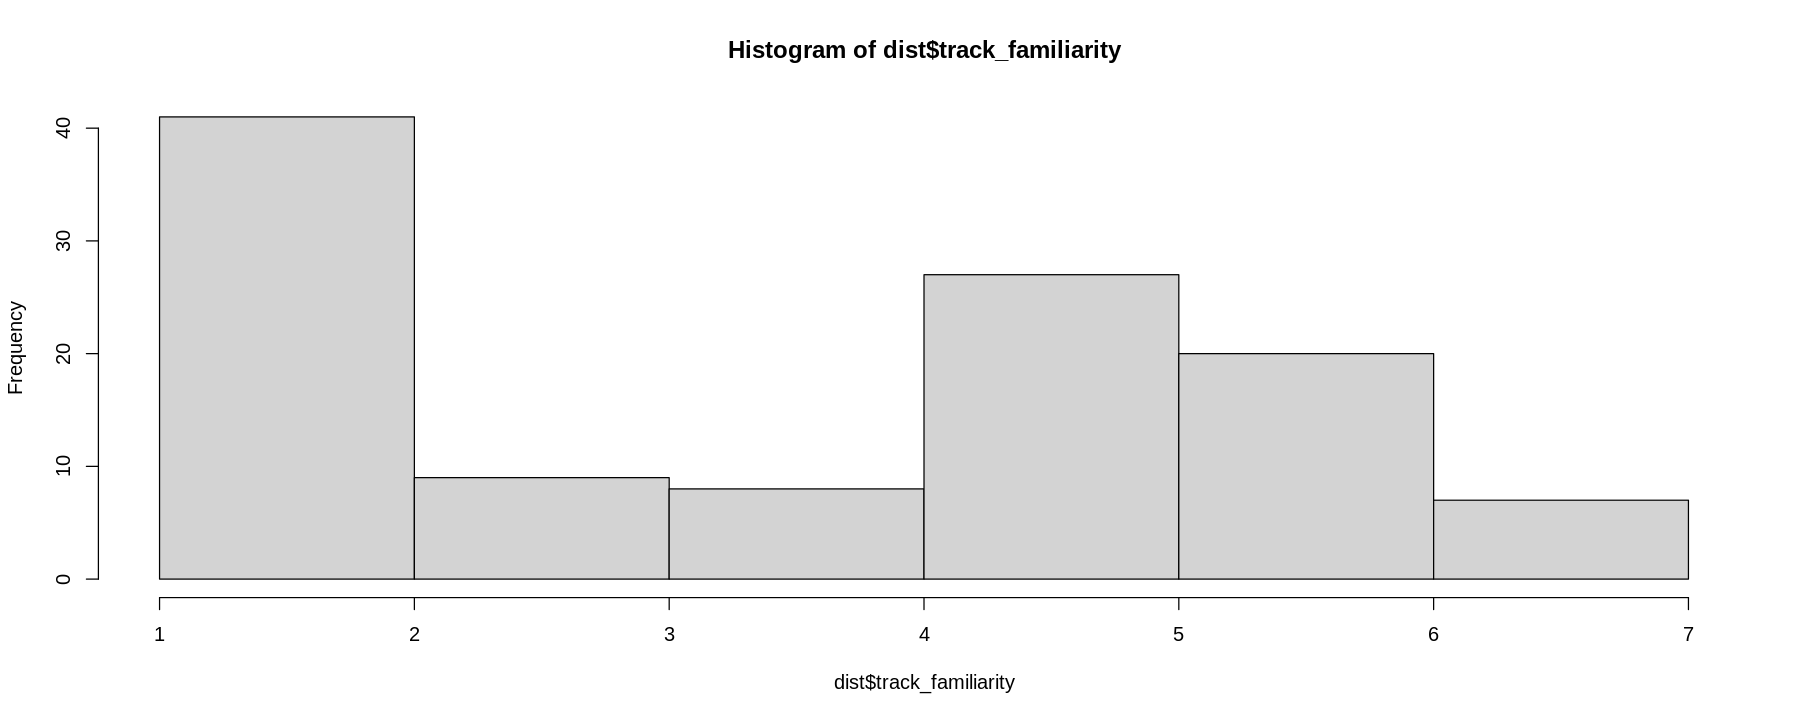

In [37]:
hist(dist$track_familiarity)

When we test for a potential relationship between pupil size and liking or familiarity, we should keep in mind that liking/familiarity ratings are ordinal data, so equal distance between points on the scale cannot be assumed. One way to handle this is to recode ratings into "low" and "high" categories, and test for a difference in pupil size between these groups. Below, this is demonstrated for liking ratings.





In [38]:
filtered$likingcat <- with(filtered, ifelse(liking < 5, "low", "high"))
filtered$likingcat <- as.factor(filtered$likingcat)
filtered$likingcat <- relevel(filtered$likingcat, ref = "low" )

In [43]:
pupilxLikingcat <- aggregate(npupil ~ liking + likingcat + ID + spotify_id + session, filtered, mean)

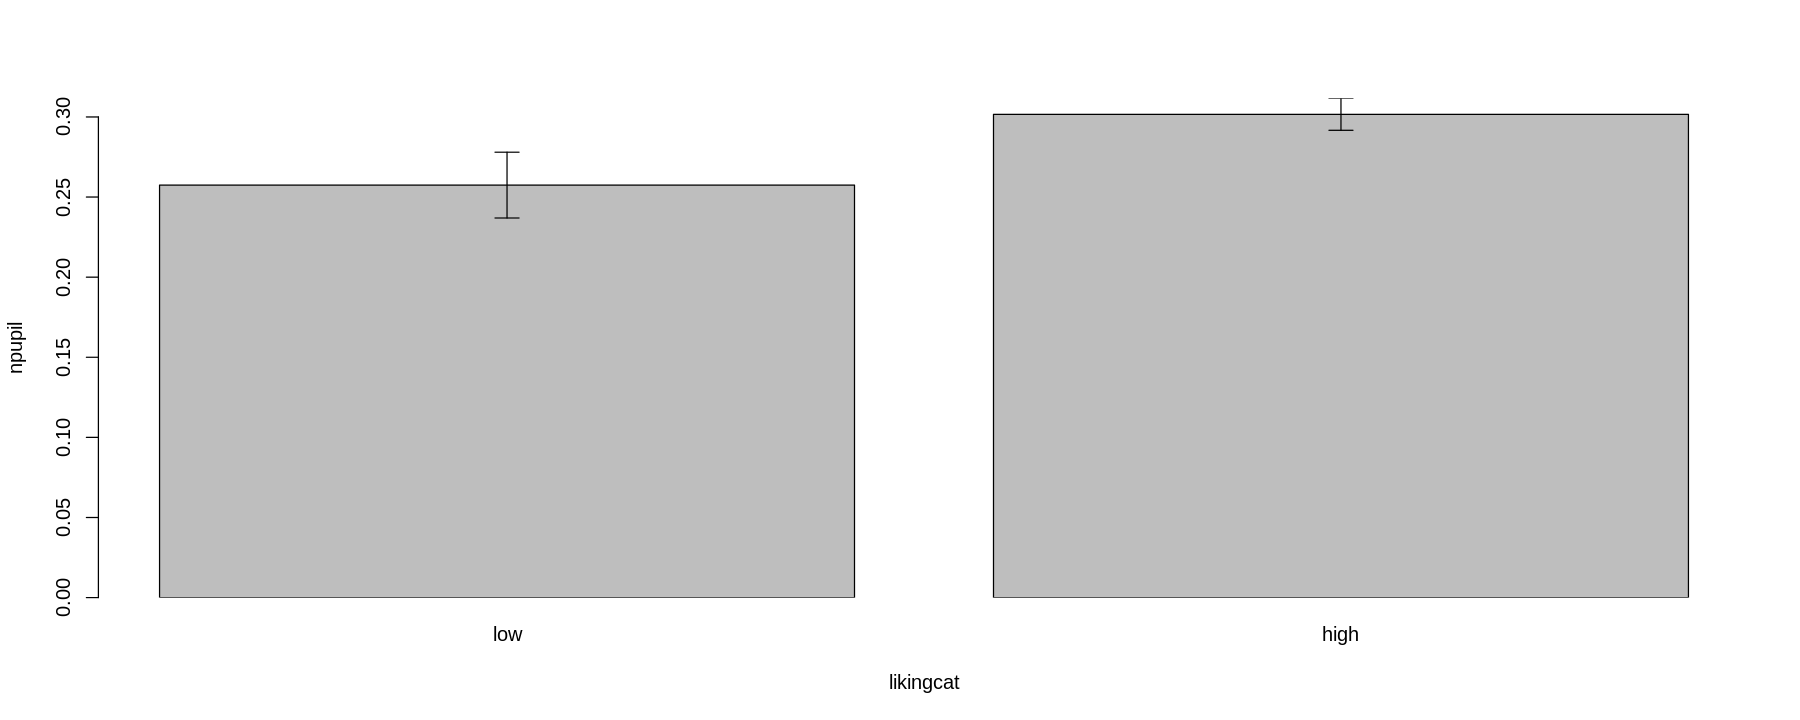

In [44]:
bargraph.CI(likingcat, npupil, data = pupilxLikingcat) # Test also with session as grouping variable

In [45]:
t.test(pupilxLikingcat[pupilxLikingcat$likingcat == "low", c("npupil")],
pupilxLikingcat[pupilxLikingcat$likingcat == "high", c("npupil")], paired = F)


	Welch Two Sample t-test

data:  pupilxLikingcat[pupilxLikingcat$likingcat == "low", c("npupil")] and pupilxLikingcat[pupilxLikingcat$likingcat == "high", c("npupil")]
t = -1.9349, df = 28.648, p-value = 0.06293
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.090856985  0.002542453
sample estimates:
mean of x mean of y 
0.2574646 0.3016219 


The relationship between pupil size and liking and/or familiarity ratings can also be tested without recoding the variables. Here, we use linear mixed effects modelling to test whether liking and familiarity predict pupil size. Participant ID is included here a a random effect.

In [ ]:
install.packages(c("lme4", "lmerTest"), lib = "/usr/local/lib/R/site-library")
lapply(c("lme4", "lmerTest"), require, character.only = TRUE)

In [47]:
pertrial <- aggregate(cbind(liking, track_familiarity, smooth.pupil) ~ ID + spotify_id + session, filtered, mean)

In [48]:
summary(model <- lmer(smooth.pupil ~ liking + track_familiarity + session + (1|ID),
              data = pertrial))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: smooth.pupil ~ liking + track_familiarity + session + (1 | ID)
   Data: pertrial

REML criterion at convergence: -95.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5669 -0.6457 -0.1389  0.5612  3.6732 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.11480  0.3388  
 Residual             0.01464  0.1210  
Number of obs: 112, groups:  ID, 9

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         2.950756   0.130109  13.624146  22.679 3.25e-12 ***
liking              0.023734   0.009875 100.504594   2.403   0.0181 *  
track_familiarity  -0.006805   0.010456 101.721477  -0.651   0.5166    
session            -0.071185   0.038343 101.236664  -1.857   0.0663 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) liking trck_f
likin

In [49]:
summary(model <- lmer(smooth.pupil ~ liking*session + track_familiarity*session + (1|ID),
              data = pertrial))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: smooth.pupil ~ liking * session + track_familiarity * session +  
    (1 | ID)
   Data: pertrial

REML criterion at convergence: -85.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5684 -0.6026 -0.1283  0.5731  3.8288 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.11419  0.3379  
 Residual             0.01461  0.1209  
Number of obs: 112, groups:  ID, 9

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                3.13767    0.19924 56.13790  15.748   <2e-16 ***
liking                     0.01390    0.02842 98.22129   0.489   0.6259    
session                   -0.21808    0.11683 98.09292  -1.867   0.0649 .  
track_familiarity         -0.04057    0.02807 98.81682  -1.446   0.1515    
liking:session             0.00573    0.01948 98.20289   0.294   0.7693    
session:track_familiarit

**Conclusions.** When we include liking, familiarity, and session as separate fixed effects in the model, there is a significant positive effect of liking on pupil size. When we instead model the interactions between i) liking x session and ii) familiarity x session, the effect of liking is no longer significant. The main effect of session is strongest (though not quite significant).

### 2.3 Does pupil size predict listeners' emotional response?
Most eye-tracking software has a function for Area of Interest (AOI) analysis. Typically, the experimenter draws AOIs on the visual display that participants viewed during the experiment. The software function then run, and outputs "hits" for each sample (or fixation) where gaze position was recorded in any of the defined AOIs.

In our experiment, participants viewed the Circumplex model while listening to each track. They were instructed to look at the term(s) that best represented their emotional response to the music. They could look at different terms, one after another, if their emotional state changed as they listened.

#### 2.3.1 Percentage of experiment time spent looking at emotion terms
An important question to address before analysing these data is how much time participants actually spend looking at one or another of the AOIs. We test this below by summing up the total number of data samples in which an AOI hit was recorded, and taking this sum as a percentage of the total number of data samples:

In [ ]:
aoi.data <- read.table("ET-partial2.txt")

In [ ]:
AOI.only <- aoi.data[!is.na(aoi.data$AOI.hit..Pleasant.), grepl("AOI", colnames(aoi.data))]
sum.of.hits <- rowSums(AOI.only)
mean(sum.of.hits, na.rm = T)*100

Across all participants and trials, only about 53% of listening time was spent with gaze fixed on one or another of the emotion terms. This is perhaps unsurprising, as participants might have needed some time to listen to the music and reflect before selecting an emotion. In the plot below, we show the position of all gaze data collected during the experiment relative to the Circumplex model. Non-AOI data is in dark blue, and AOI hits are in in light blue.

In [ ]:
aoi.data$hit <- rowSums(aoi.data[, grepl("AOI", colnames(aoi.data))])
hits <- aoi.data[aoi.data$hit == 1, ]

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 11)
with(aoi.data[aoi.data$session == 1, ],
     plot(Gaze.point.X, Gaze.point.Y, col = "navy", bty = "n"))
with(hits,
     points(Gaze.point.X, Gaze.point.Y, col = "dodgerblue"))
text(c(.5, .5, .8, .19), c(.9, .1, .5, .5),
     label = c("ACTIVATION", "DEACTIVATION", "PLEASANT", "UNPLEASANT"),
     cex = 1.2)
text(c(.62, .67, .72, .77, .77, .72, .67, .59, .38, .30, .25, .21, .21, .26, .32, .4),
     c(.83, .77, .69, .62, .40, .29, .21, .15, .15, .21, .29, .40, .62, .69, .77, .83),
     label = c("alert", "excited", "elated", "happy", "contented", "serene", "relaxed", "calm",
               "fatigued", "lethargic", "depressed", "sad", "upset", "stressed", "nervous", "tense"),
     cex = 1.2)

#### 2.3.2 Which emotions did participants experience while listening?
Below, we calculate the percentage of data samples where AOI hits were recorded for each of the different terms on the Circumplex model. The plot below represents the distribution of emotional responses that arose across the participant sample during the experiment.

In [ ]:
options(repr.plot.width = 23, repr.plot.height = 6)
plot(colSums(AOI.only)/sum(sum.of.hits)*100, xaxt = "n",
      pch = 19, cex = 2,
      xlab = "Emotions", ylab = "% total samples", cex.lab = 1.5,
      main = "Listeners' emotional responses to music", cex.main = 1.5)
axis(1, at = 1:20, labels = mgsub(colnames(AOI.only), c("AOI.hit", "\\."), c("", "")))
abline(v = c(4.5, 8.5, 12.5, 16.5), lty = 2, col = "grey", lwd = 2)

In [ ]:
aoi.data$quadActPleas <- rowSums(aoi.data[,c(9, 10, 13:16)])
aoi.data$quadDeactPleas <- rowSums(aoi.data[,c(10, 11, 17:20)])
aoi.data$quadDeactUnpleas <- rowSums(aoi.data[,c(11, 12, 21:24)])
aoi.data$quadActUnpleas <- rowSums(aoi.data[,c(9, 12, 25:28)])

In [ ]:
quad.df <- data.frame(ID = aoi.data$ID,
                      spotify_id = aoi.data$spotify_id,
                      session = aoi.data$session,
                      smooth.pupil = aoi.data$smooth.pupil,
                      npupil = aoi.data$npupil,
                      quadsums = c(aoi.data$quadActPleas, aoi.data$quadDeactPleas,
                                  aoi.data$quadDeactUnpleas, aoi.data$quadActUnpleas),
                      quadlabel = c(rep("ActPleas", nrow(aoi.data)), rep("DeactPleas", nrow(aoi.data)),
                                    rep("DeactUnpleas", nrow(aoi.data)), rep("ActUnpleas", nrow(aoi.data))))
quad.hit <- quad.df[quad.df$quadsums == 1, ]

In [ ]:
bargraph.CI(quadlabel, quadsums*100, session, data = quad.df, legend = T,
            xlab = "Circumplex quadrant", ylab = "Percentage of total AOI hits",
            x.leg = 10, y.leg = .25, cex.leg = 1.5, leg.lab = c("Session 1", "Session 2"))

In [ ]:
pupilxQuad <- aggregate(npupil ~ quadlabel + ID + spotify_id + session, quad.hit, mean,
                        na.action = na.pass, na.rm = T)

In [ ]:
bargraph.CI(quadlabel, npupil, data = pupilxQuad,
            xlab = "Circumplex quadrant", ylab = "Pupil size")

In [ ]:
pupilxQuad$Activation <- with(pupilxQuad, ifelse(grepl("Act", quadlabel), "Act", "Deact"))

In [ ]:
t.test(pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")],
       pupilxQuad[pupilxQuad$quadlabel == "ActUnpleas", c("npupil")])

In [ ]:
t.test(pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")],
       pupilxQuad[pupilxQuad$quadlabel == "DeactPleas", c("npupil")])

In [ ]:
t.test(pupilxQuad[pupilxQuad$quadlabel == "ActPleas", c("npupil")],
       pupilxQuad[pupilxQuad$quadlabel == "DeactUnpleas", c("npupil")])

**Conclusions.** Participants' emotional response to the music they heard was mostly positive: most AOI hits were in the pleasant-deactivation quadrant, followed by the pleasant-activation quadrant. Notably, hits were more evenly distributed between the two quadrants in the second listening session. Pupil size was largest when participants experienced pleasant activation, and smallest when participants experienced unpleasant deactivation. The effect of activation is in line with the idea that pupil dilation occurs during cognitive arousal. The added effect of pleasant emotions suggeest that participants might have been more engaged by music that elicited a pleasant emotional response.